# cath-classes
Analyzing elements of the CATH class distribution

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [68]:
cath_annotation_frame  = pd.read_table("../data/domain-classifications.tsv")
cath_topol_idxmap = dict(map(lambda x: x[::-1], enumerate(sorted(cath_annotation_frame.TOPOL.unique()))))
cath_annotation_frame['class'] = cath_annotation_frame.TOPOL.apply(cath_topol_idxmap.get) 

with open("../data/cath-dataset-nonredundant-S40.list", 'r') as caths40:
    cath_s40_domains = list(map(lambda x: x.strip(), caths40))
    
#cath_annotation_frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(cath_s40_domains)].copy()
print(len(cath_annotation_frame), len(cath_s40_domains))
cath_annotation_frame.head()

434857 30739


,DOMAIN,CLASS,ARCH,TOPOL,HOMOL,class
0,1oaiA00,Mainly Alpha,Orthogonal Bundle,"Helicase, Ruva Protein; domain 3","DNA helicase RuvA subunit, C-terminal domain",510
1,1go5A00,Mainly Alpha,Orthogonal Bundle,"Helicase, Ruva Protein; domain 3","DNA helicase RuvA subunit, C-terminal domain",510
2,3frhA01,Mainly Alpha,Orthogonal Bundle,"Helicase, Ruva Protein; domain 3","DNA helicase RuvA subunit, C-terminal domain",510
3,3friA01,Mainly Alpha,Orthogonal Bundle,"Helicase, Ruva Protein; domain 3","DNA helicase RuvA subunit, C-terminal domain",510
4,3b89A01,Mainly Alpha,Orthogonal Bundle,"Helicase, Ruva Protein; domain 3","DNA helicase RuvA subunit, C-terminal domain",510


In [3]:
vc    = cath_annotation_frame['class'].value_counts()

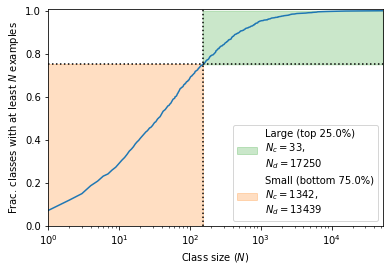

In [77]:
def accumulate_topology_by_size():
    vc = cath_annotation_frame['class'].value_counts()
    counts = vc.values
    size_freqs = Counter(counts)
    unique_sizes = sorted(list(size_freqs.keys()))
    accumulated_topols = np.array([len(vc[vc <= sz]) for sz in unique_sizes]) / len(vc)
    
    return unique_sizes, accumulated_topols

def accumulate_topology_by_size_plot(ax, frac=0.75, alpha=0.25, label=None, title=False):
    unique_sizes, accumulated_topols = accumulate_topology_by_size()
    ax.plot(unique_sizes, accumulated_topols, label=label)

    if frac is not None:
        closest = min(accumulated_topols, key=lambda x: abs(x - frac))
        idx     = list(accumulated_topols).index(closest)
        xval    = unique_sizes[idx]
        low  = vc[vc < xval]
        high = vc[vc > xval]
    
        nc_high, nc_low = map(len, (low, high))
        n_high , n_low  = map(sum, (low, high))
    
        ax.axvline(xval, linestyle=':', color='k')
        ax.axhline(closest, linestyle=':', color='k')
    
        pct_high, pct_low = frac*100, (1 - frac)*100
        
        lb_lbl = f"Small (bottom {pct_high:0.1f}%)\n$N_c={nc_high}$,\n$N_d={n_high}$"
        ub_lbl = f"Large (top {pct_low:0.1f}%)\n$N_c={nc_low}$,\n$N_d={n_low}$"
    
        # upper
        ax.fill_between(range(xval, max(unique_sizes)), closest, 1.,
                         alpha=alpha, label=ub_lbl, color='C2')
    
        # lower
        ax.fill_between(range(xval+1), 0., closest,
                        alpha=alpha, label=lb_lbl, color='C1')
    
    ax.set_ylim(0, 1.01)
    ax.set_xlim(min(unique_sizes), max(unique_sizes))
    ax.set_xscale('log')
    if title:
        ax.set_title(f"Accumulation by size of {len(vc)} topologies")
    ax.set_xlabel("Class size ($N$)")
    ax.set_ylabel("Frac. classes with at least $N$ examples")
    return accumulated_topols

ax = plt.gca()
accumulate_topology_by_size_plot(ax)
ax.legend()
plt.savefig("figs/accumulate_topology_by_size.pdf")
plt.show()

Above shows how topologies accumulate as a function of the number of samples each topology contains. In other words: for a given class size, how many topologies have _at least_ that many.


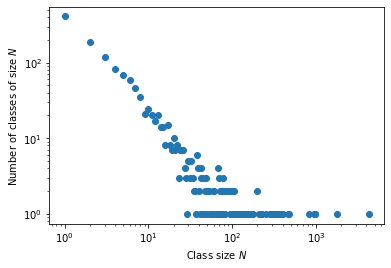

In [78]:
counts, values = zip(*sorted(Counter(vc.values).items(), key=lambda k: k[1], reverse=True))
plt.scatter(counts, values)
plt.xlabel("Class size $N$")
plt.ylabel("Number of classes of size $N$")
plt.xscale('log')
plt.yscale('log')
plt.savefig("figs/cath_topology_size_distribution.pdf")

 Here we're showing the exponential size distribution of classes on a log-log axis. 

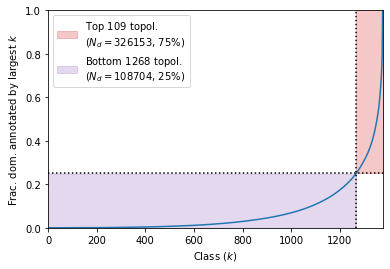

In [79]:
def accumulate_by_domain():
    vc = cath_annotation_frame['class'].value_counts().sort_values(ascending=True)
    cumul = np.cumsum(vc.values)
    
    return range(len(cumul)), cumul
def accumulate_by_domain_plot(ax, frac=0.25, label=None, alpha=0.25):
     # cumulative total of domains recruited per class
    xs, cumul = accumulate_by_domain()      
    prop = cumul / cumul[-1]
    ax.plot(xs, prop, label=label)
    if frac is not None:
        closest = min(prop, key=lambda x: abs(x - frac))
        idx     = list(prop).index(closest)
        xval    = idx + 1
        # plot cross lines
        ax.axvline(xval, linestyle=':', color='k')
        ax.axhline(closest, linestyle=':', color='k')
        # fill regions
        # lower box
        pct = int((1-frac)*100)
        ub_lbl = f"Top ${len(cumul) - (idx + 1)}$ topol.\n($N_d={cumul[-1] - cumul[idx]}$, {pct}%)"
        ax.fill_between(range(idx, len(cumul)), frac, 1., 
                        alpha=alpha, color='C3', label=ub_lbl)

        # upper box
        pct = int(frac * 100)
        lb_lbl = f"Bottom ${(idx + 1)}$ topol.\n($N_d={cumul[idx]}$, {pct}%) "
        ax.fill_between(range(0, idx), 0., closest, 
                        alpha=alpha, color='C4', label=lb_lbl)
    ax.set_ylim(0, 1.)
    ax.set_xlim(0, len(cumul))
    ax.set_xlabel("Class ($k$)")
    ax.set_ylabel("Frac. dom. annotated by largest $k$")
   
ax = plt.gca()
accumulate_by_domain_plot(ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.savefig("figs/accumulate_domain_by_topology.pdf")

plt.show()

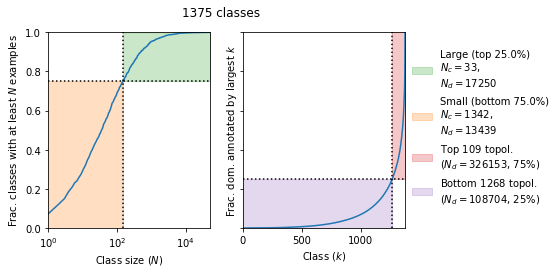

In [85]:
a = 0.75
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6.4, 4.8*a))
#plt.subplots_adjust(right=0.7)
accumulate_topology_by_size_plot(ax1)
accumulate_by_domain_plot(ax2)
ax1_h, ax1_la = ax1.get_legend_handles_labels()
ax2_h, ax2_la = ax2.get_legend_handles_labels()
#ax2.legend([*ax1_h, *ax2_h], [*ax1_la, *ax2_la])
fig.legend(frameon=False, bbox_to_anchor=(1.21, 0.9))
fig.suptitle(f"{len(vc)} classes")
#plt.tight_layout(rect=[0, 0, 1, .75])

plt.savefig("figs/cumulative_class_distribution.pdf", bbox_inches='tight')
plt.show()

Here we are showing the fraction of _domains_ recovered per topology. That is, given the top $k$ classes, how many samples are included? This view is different from the per-sample perspective; whereas before we accumulated topologies, here we accumulate domains.

In [69]:
import re
import gzip

def chunks(iterable, chunk_sz=6):
    chunk = []
    for i, it in enumerate(iterable):
        if i and not i % chunk_sz:
            yield chunk
            chunk = []
        chunk.append(it)
    if chunk:
        yield chunk

ct = 0
pdb_ln  = re.compile(".*/(.{7})\.pdb")  # gets the pdb filename
len_ln  = re.compile("Length of Chain_\d:\s(\d+)\sresidues") # gets the pdb length
tmsc_ln = re.compile("TM-score=\s(\d+\.\d+)")

domain_to_class = dict(cath_annotation_frame[['DOMAIN', 'class']].values)
get_match = lambda x: x.groups()[0]
columns = ['cath1', 'cath2', 'L1', 'L2', 'TM_wrt_cath1', 'TM_wrt_cath2', 'class']
rows = []
with gzip.open("../data/all.tmscore.gz", 'rb') as gz:
    for lines in chunks(gz):
        lines = list(map(lambda line: line.decode().strip(), lines))
        pdb1, pdb2, len1, len2, tmsc1, tmsc2 = lines
        cath_id1, cath_id2 =          map(get_match, map(pdb_ln.match, (pdb1, pdb2)))
        len1, len2         = map(int, map(get_match, map(len_ln.match, (len1, len2))))
        tmsc1, tmsc2       = map(float, map(get_match, map(tmsc_ln.match, (tmsc1, tmsc2))))
        c1, c2 = domain_to_class[cath_id1], domain_to_class[cath_id2]
        assert c1 == c2
        row = dict(zip(columns, [cath_id1, cath_id2, len1, len2, tmsc1, tmsc2, c1]))
        rows.append(row)
        #print(*map(lambda line: line.decode().strip(), lines), sep='\n')
        
intra_topol_tmscore_frame = pd.DataFrame(rows)

In [70]:
intra_topol_tmscore_frame['max_tmscore'] = intra_topol_tmscore_frame.apply(lambda row: max(row.TM_wrt_cath1, row.TM_wrt_cath2), axis='columns')
intra_topol_tmscore_frame['min_tmscore'] = intra_topol_tmscore_frame.apply(lambda row: min(row.TM_wrt_cath1, row.TM_wrt_cath2), axis='columns')

cls2topol = {v:k for k, v in cath_topol_idxmap.items()}
intra_topol_aggregated_tmscores = []
for cls, frame in intra_topol_tmscore_frame.groupby('class'):
    row = {'class':cls}
    row['topol'] = cls2topol[cls]
    for column in ['TM_wrt_cath1', 'TM_wrt_cath2', 'min_tmscore', 'max_tmscore']:
        row['avg_' + column] = frame[column].mean()
        row['std_' + column] = frame[column].std()
        row['med_' + column] = frame[column].median()
            
    intra_topol_aggregated_tmscores.append(row)
intratopol_aggframe = pd.DataFrame(intra_topol_aggregated_tmscores)

cls_sz = dict(vc)
intratopol_aggframe['class_size'] =  intratopol_aggframe['class'].apply(cls_sz.get)

No handles with labels found to put in legend.


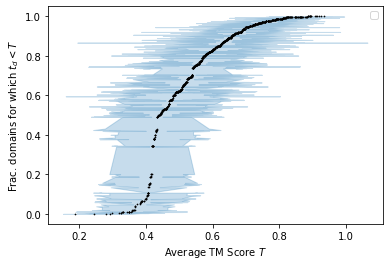

In [71]:
def domain_enrichment_per_tmscore_avg(ax, title=False):
    cls_sz = dict(vc)

    frame = intratopol_aggframe.sort_values(by='avg_TM_wrt_cath1')
    cumfrac_annotated = np.cumsum(frame.class_size.values) / frame.class_size.sum()
    avg_tmscore = frame.avg_TM_wrt_cath1.values
    std_tmscore = frame.std_TM_wrt_cath2.values

    mean_csize = frame.class_size.mean()
    std_csize  = frame.class_size.std()

    #ax.scatter(avg_tmscore, cumfrac_annotated, s=frame.class_size.values,
    #         marker='H',
    #         #linestyle='none',
    #         #fillstyle='none'
    #         facecolors='none',
    #         edgecolors='grey', alpha=0.4, label='Class size')
    ax.plot(avg_tmscore, cumfrac_annotated, color='k', linestyle='none', marker='o', markersize=0.7)
    #ax.bar(avg_tmscore, frame.class_size.values / frame.class_size.sum(), alpha=0.1)
    ax.fill_betweenx(cumfrac_annotated, avg_tmscore - std_tmscore, avg_tmscore + std_tmscore,
                      alpha=0.25, color='C0')
    
    if title: ax.set_title("Cumulative domain enrichment per TM-score")
    ax.set_ylabel("Frac. domains for which $t_d < T$")
    ax.set_xlabel("Average TM Score $T$")
    ax.legend(markerscale=0.4)
    #lgnd.legendHandles[1]._legmarker.set_markersize(6)
        
ax = plt.gca()
domain_enrichment_per_tmscore_avg(ax)
plt.show()

No handles with labels found to put in legend.


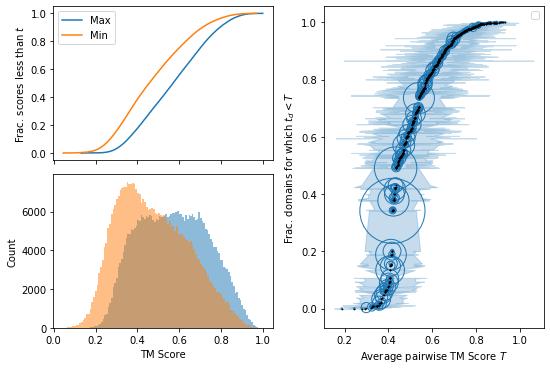

In [84]:

shape = (2, 2)
a, b = 1.25, 1.25
fig   = plt.figure(figsize=(6.2*b,4.2*a))
ax1 = plt.subplot2grid(shape, (1, 0), rowspan=1, colspan=1) # cumulative tm
ax2 = plt.subplot2grid(shape, (0, 0), rowspan=1, colspan=1) # histograms
ax3 = plt.subplot2grid(shape, (0, 1), rowspan=2, colspan=1) # domain enrichment per avg
axarr = [ax1, ax2, ax3]
#axarr[0].text(0.5, 0.5, 0)


## Cumulative TMScore distributions
tms1   = sorted(intra_topol_tmscore_frame.max_tmscore.values)
tms2   = sorted(intra_topol_tmscore_frame.min_tmscore.values)

props1 = np.array(range(len(tms1))) / len(tms1)
props2 = np.array(range(len(tms2))) / len(tms2)

axarr[1].set_xticks(axarr[2].get_xticks())
axarr[1].set_xticklabels([])
axarr[1].set_ylabel("Frac. scores less than $t$")

axarr[1].plot(tms1, props1, label='Max')
axarr[1].plot(tms2, props2, label='Min')
axarr[1].legend(loc='upper left')

## TMscore Histograms
axarr[0].hist(intra_topol_tmscore_frame.max_tmscore.values, bins=110, alpha=0.5)
axarr[0].hist(intra_topol_tmscore_frame.min_tmscore.values, bins=110, alpha=0.5)
axarr[0].set_xlabel("TM Score")
axarr[0].set_ylabel("Count")

## Cumulative domain enrichment per TM
frame = intratopol_aggframe.sort_values(by='avg_TM_wrt_cath1')
cumfrac_annotated = np.cumsum(frame.class_size.values) / frame.class_size.sum()
avg_tmscore = frame.avg_TM_wrt_cath1.values
std_tmscore = frame.std_TM_wrt_cath2.values

domain_enrichment_per_tmscore_avg(axarr[2])
axarr[2].scatter(avg_tmscore, cumfrac_annotated, s=frame.class_size.values, facecolor='none', color='C0')
#axarr[2].plot(avg_tmscore, cumfrac_annotated, color='C0')

#axarr[2].fill_betweenx(cumfrac_annotated, avg_tmscore - std_tmscore, avg_tmscore + std_tmscore, alpha=0.25)
#axarr[2].plot(avg_tmscore - std_tmscore, cumfrac_annotated, alpha=0.25, color='C0', linewidth=0.8)
#axarr[2].plot(avg_tmscore + std_tmscore, cumfrac_annotated, alpha=0.25,color='C0')

#axarr[2].set_title("Cumulative domain enrichment per TM-score")
#axarr[2].set_ylabel("Frac. domains $d$ for which $t_d < T$")
#
axarr[2].set_xlabel("Average pairwise TM Score $T$")
#axarr[2].plot(frame.class_size.values / frame.class_size.sum())

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig("figs/TMscore_distributions.pdf")
plt.show()